In [1]:
import os; os.chdir('..')

In [2]:
from jobs.specs import dev_vaei3d_smth_ce_kld_mse as opts
from models.vae_i3d import VAEI3D
from pipeline.smth import SmthDataBunch
from models.engine import _prepare_batch
import constants as ct

import dataclasses as dc
import torch as th
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def picshow(video):
    num = len(video)
    fig = plt.figure(figsize=(16, 32), dpi=80)
    for i in range(1,num+1):
        sub = fig.add_subplot(1,num,i)
        sub.set_title(str(i))
        sub.axis('off')
        sub.imshow(video[i-1])
    plt.show()

def unnormalize(x):
    return x * 255

def unstandardize(x):
    means = th.tensor(ct.IMAGE_NET_MEANS).reshape((1, 3, 1, 1))
    stds = th.tensor(ct.IMAGE_NET_STDS).reshape((1, 3, 1, 1))
    
    return x * stds + means

In [4]:
opts.trainer_opts.optimizer_opts.lr = 0.005
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

model = VAEI3D(**dc.asdict(opts.model_opts)).to(device)
bunch = SmthDataBunch(opts.db_opts, opts.train_ds_opts, opts.valid_ds_opts, opts.train_dl_opts, opts.valid_dl_opts)
optimizer = opts.trainer_opts.optimizer(model.parameters(), **dc.asdict(opts.trainer_opts.optimizer_opts))
loss_fn = opts.trainer_opts.criterion(**dc.asdict(opts.trainer_opts.criterion_opts)).to(device)
lr_scheduler = th.optim.lr_scheduler.StepLR(optimizer, 100, 0.5)

In [5]:
batch = next(iter(bunch.valid_loader))
video, label = bunch.valid_set[0]
x, y = _prepare_batch(batch, device, False)

In [6]:
video, label

(Video 42326 (4x3x224x224), (8 Spreading something onto something))

In [7]:
for _ in range(100):
    model.train()
    optimizer.zero_grad()
    _recon, _pred, _latent, _mean, _log_var = model(x, inference=False, max_likelihood=False, num_samples=0)
    mse, ce, kld = loss_fn(_recon, _pred, x, y, _mean, _log_var)
    (mse + ce + kld).backward()
    print(f'{_}={mse:.4f} | {kld:.4f} | {ce:.4f}')
    optimizer.step()
    lr_scheduler.step()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation

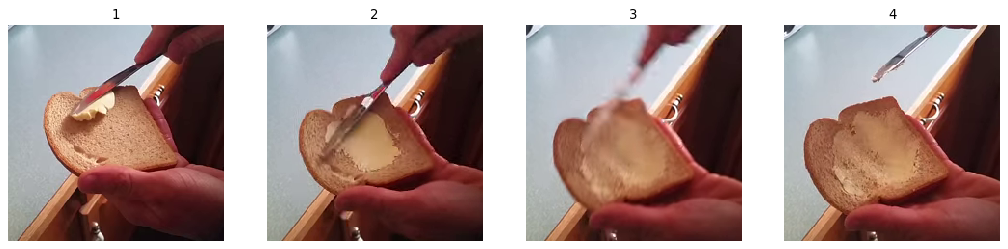

In [8]:
_in = video.data.astype(np.int).swapaxes(1,2).swapaxes(2,3)
picshow(_in)

[2019-05-31 10:53:59,779][29164][WARNING]	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


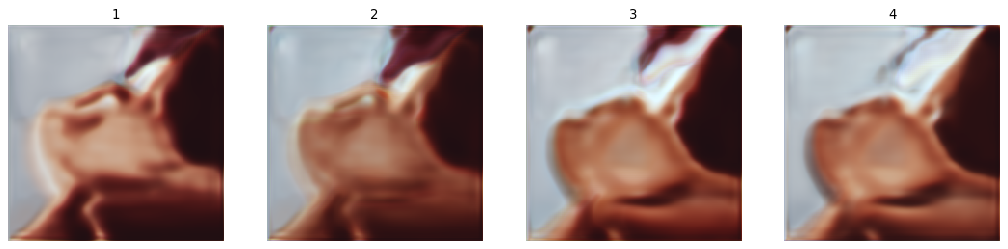

In [9]:
_rec = unnormalize(unstandardize(_recon.detach().cpu()))
_rec = _rec.numpy().reshape(4, 3, 224, 224).astype(np.int).swapaxes(1,2).swapaxes(2,3)
picshow(_rec)

In [12]:
_recon.min(), _recon.max(), _rec.min(), _rec.max()

(tensor(-1.7751, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(2.8656, device='cuda:0', grad_fn=<MaxBackward1>),
 14,
 267)

In [15]:
unstandardize(_recon.detach().cpu()).min(), unstandardize(_recon.detach().cpu()).max()

(tensor(0.0584), tensor(1.0508))